*Сделать анализ датасета. Построить не менее 10 картинок, графиков, диаграмм.*
*По каждой картинке сделать небольшой вывод.*

In [1]:
# Делаем необходимые импорты

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style='whitegrid', palette='deep')

In [2]:
# Читаем файл с данными по игрокам, сразу парсим даты рождения.
# Выводим первые 10 записей.

players_df = pd.read_csv(filepath_or_buffer="player_data.csv", parse_dates=["birth_date"])
players_df.head()

,name,year_start,year_end,position,height,weight,birth_date,college
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,1968-06-24,Duke University
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,1946-04-07,Iowa State University
2,Kareem Abdul-Jabbar,1970,1989,C,7-2,225.0,1947-04-16,"University of California, Los Angeles"
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,1969-03-09,Louisiana State University
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,1974-11-03,San Jose State University


In [3]:
# обнаруживаем, что рост указан в "футах-дюймах", а вес в фунтах
# смотрим сводную информацию по датасету

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name        4550 non-null   object        
 1   year_start  4550 non-null   int64         
 2   year_end    4550 non-null   int64         
 3   position    4549 non-null   object        
 4   height      4549 non-null   object        
 5   weight      4544 non-null   float64       
 6   birth_date  4519 non-null   datetime64[ns]
 7   college     4248 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 284.5+ KB


In [4]:
# Видим, что данные по росту отсутствуют у одного спортсмена
# полагаю, что данным спортсменом можно пренебречь, удаляем его 

players_df.dropna(subset=["height"], inplace=True)

In [5]:
# Как мы заметили ранее, рост указан в "футах-дюймах", а вес в фунтах.
# Выполняем необходимые преобразования

def height_in_cm(h):
    f, i = map(int, h.split("-"))
    return int((f*12 + i) * 2.54)

players_df["height"] = players_df["height"].apply(height_in_cm)
players_df["weight"] = round(players_df["weight"] * 0.45359237, 2)

In [6]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4549 entries, 0 to 4549
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   name        4549 non-null   object        
 1   year_start  4549 non-null   int64         
 2   year_end    4549 non-null   int64         
 3   position    4549 non-null   object        
 4   height      4549 non-null   int64         
 5   weight      4544 non-null   float64       
 6   birth_date  4518 non-null   datetime64[ns]
 7   college     4247 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 319.9+ KB


In [7]:
# Теперь с ростом все ОК, но отсутствуют данные по весу 5 спортсменов. Посмотрим на них

players_df[players_df["weight"].isna()]

,name,year_start,year_end,position,height,weight,birth_date,college
2360,Dick Lee,1968,1968,F,198,NaN,NaT,University of Washington
2783,Murray Mitchell,1950,1950,C,198,NaN,1923-03-19,Sam Houston State University
2973,Paul Nolen,1954,1954,C,208,NaN,1929-09-03,Texas Tech University
4279,Ray Wertis,1947,1948,G,180,NaN,1922-01-01,St. John's University
4472,Bob Wood,1950,1950,G,177,NaN,1921-10-07,Northern Illinois University


## histplot, boxplot

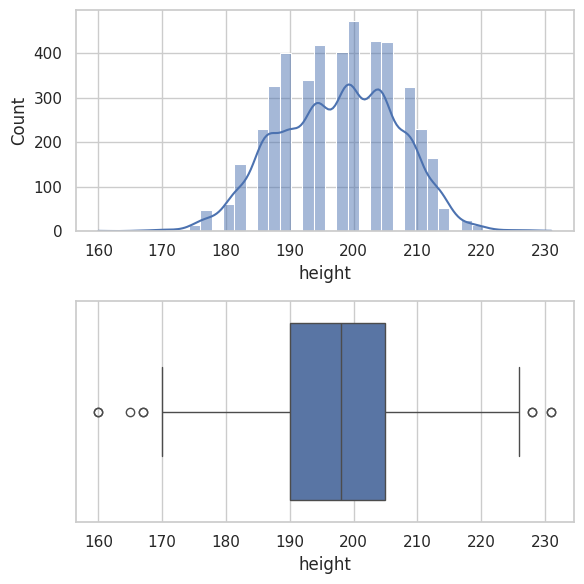

In [8]:
# Первая мысль - заполнить отсутствующие данные медианными значениями, 
# но обращаем внимание на то, что у двух спортсменов не особо высокий рост 
# для баскетболистов. Проверим эту догадку, построив графики распределения 
# роста спортсменов

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.histplot(data=players_df, x='height', kde=True, ax=axes[0])
sns.boxplot(data=players_df, x="height", ax=axes[1])
fig.tight_layout()

In [9]:
# Действительно, мы видим, что основное распределение роста спортсменов
# находится в диапазоне от 190 до 205 см, поэтому присваивать "малышам"
# средний вес "великанов", вероятно, не лучшая идея.
# Поэтому решение такое: "малышей" без веса исключаем из выборки, а для 
# остальных устанавливаем вес в медианное значение, как и собирались.

little_guys = players_df["weight"].isnull() & (players_df["height"] < 190)
indexes_for_dropping = players_df[little_guys].index
players_df.drop(index=indexes_for_dropping, inplace=True)

# players_df = players_df[~mask]  # гениальная штука от Любомира, оставил для истории!

median_weight = players_df["weight"].median()
players_df["weight"].fillna(median_weight, inplace=True)


## histplot + kde, boxenplot

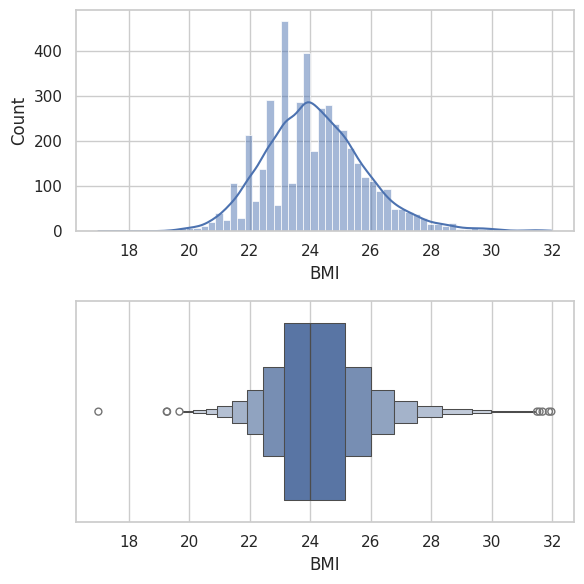

In [10]:
# Добавим показатель - индекс массы тела, который рассчитывается по формуле:
# BMI = weight (kg)/height^2 (m^2)

players_df["BMI"] = round(players_df["weight"] / (players_df["height"]/100)**2, 2)

# И посмотрим его распределение

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.histplot(data=players_df, x='BMI', kde=True, ax=axes[0])
sns.boxenplot(data=players_df, x="BMI", ax=axes[1])
fig.tight_layout()

## boxplot categorized

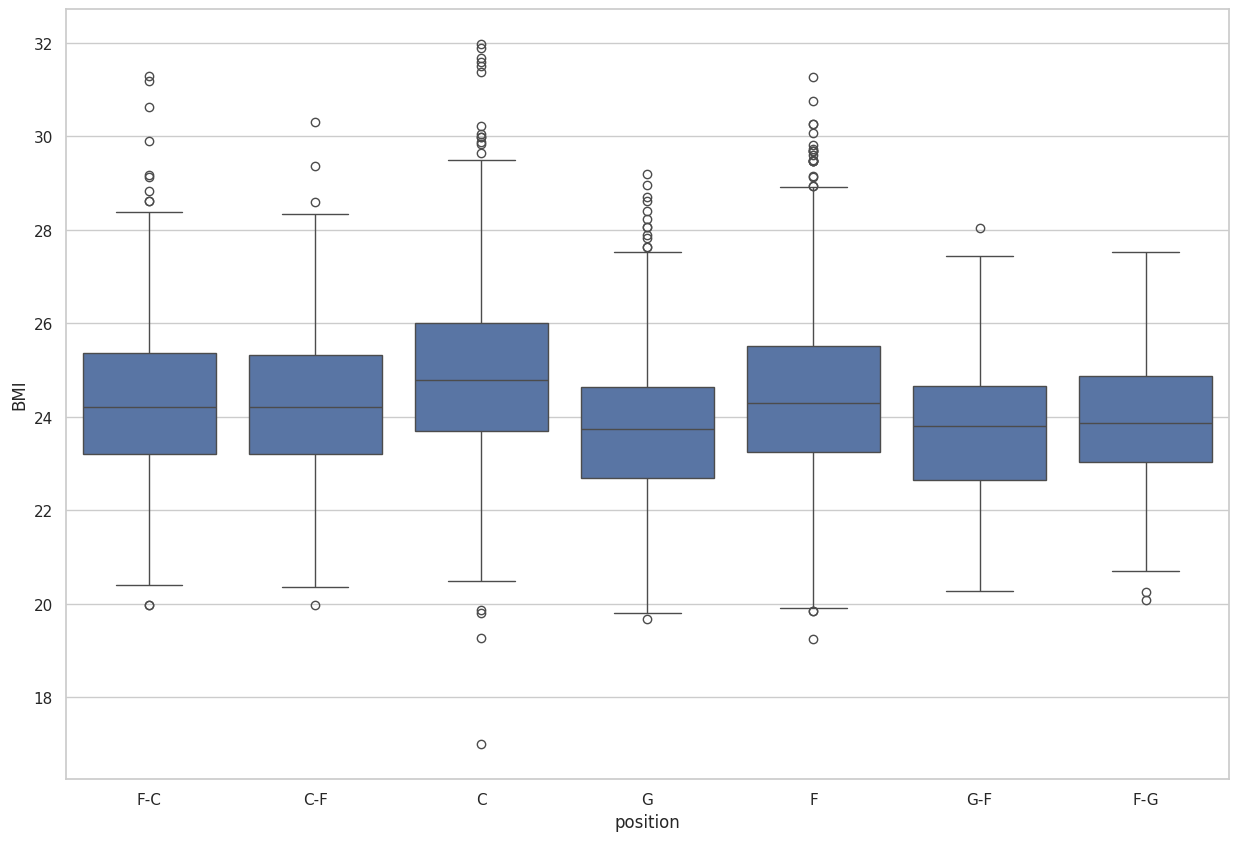

In [11]:
# Что тут можно сказать? Баскетболисты - ребята крепкие ))
# Нормой для мужчин считается значение < 25, а 25-39 - это уже лишний вес.
# В нашем датасете в этот диапазон попала половина спортсменов.
# Но не секрет, что требования к физическим кондициям для спортсменов, 
# играющим на разных позициях отличаются. # Поэтому выдвинем гипотезу: 
# ИМТ для нападающих будет ниже (более высокие и худые), # чем для защитников (более коренастые). 

plt.figure(figsize=(15, 10))
sns.boxplot(x='position', y='BMI', data=players_df)
plt.xlabel('position')
plt.ylabel('BMI')
plt.title('')
plt.show()

In [12]:
# Ну надо же, все наоборот! 
# Все амплуа с G (guard) имеют более низкий ИМТ, чем те, что с F (forward). 
# Вероятно, я перепутал баскетбол с регби )) 
# Впрочем, то, что центровые C (center) самые мощные ребята - ожидаемо.

In [13]:
# Посмотрим за какой период у нас статистика 

players_df["year_start"].agg(["min", "max"])
# len(players_df["year_start"].unique())


min    1947
max    2018
Name: year_start, dtype: int64

## lineplot

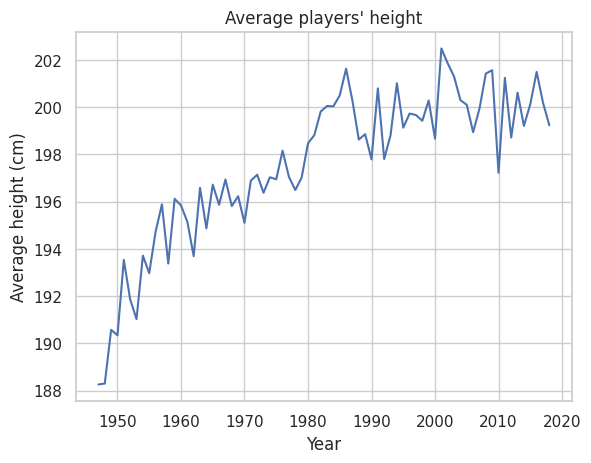

In [14]:
# 70 лет - немало. На таком разбеге интересно посмотреть как менялся средний рост игроков с течением времени

aver_height = players_df.groupby(by="year_start")["height"].mean().to_frame()

sns.lineplot(data=aver_height, x=aver_height.index, y="height")

plt.title("Average players' height")
plt.xlabel("Year")
plt.ylabel('Average height (cm)')

plt.show()

In [15]:
# Наблюдаем тенденцию к росту, что вполне логично, принимая во внимание, что 
# средний рост человечества в целом тоже увеличился   

In [16]:
# Прочитаем файл со статистикой по сезонам

stat_df = pd.read_csv("Seasons_Stats.csv")
stat_df.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [17]:
# Выведем основную информацию

stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24691 entries, 0 to 24690
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24691 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-nul

In [18]:
# Видим два полностью пустых столбика: "blanl" и "blank2". Удалим их

stat_df.drop(columns=["blanl", "blank2"], inplace=True)

# Также в файле есть полностью пустые строки (посмотрел во вьюере). Удалим их тоже

stat_df.dropna(subset="Player", inplace=True)

stat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24624 entries, 0 to 24690
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24624 non-null  int64  
 1   Year        24624 non-null  float64
 2   Player      24624 non-null  object 
 3   Pos         24624 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24624 non-null  object 
 6   G           24624 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24138 non-null  float64
 9   PER         24101 non-null  float64
 10  TS%         24538 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24525 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-null  fl

In [19]:
# Поскольку мы намереваемся соединить две таблицы - данные по игрокам с их статистикой, нам нужно подумать об ключе. 
# Очевидно, что у игроков могут быть одинаковые имена, поэтому только имени недостаточно. 
# Добавим в наши датафреймы также года рождения.

players_df["birth_year"] = players_df["birth_date"].dt.year

# Посмотрим есть ли игроки для которых год рождения неизвестен

no_year = players_df["birth_year"].isna()
players_df[no_year]

,name,year_start,year_end,position,height,weight,birth_date,college,BMI,birth_year
49,Bill Allen,1968,1968,C-F,203,92.99,NaT,New Mexico State University,22.57,NaN
317,Don Bielke,1956,1956,C,200,108.86,NaT,Valparaiso University,27.22,NaN
473,Clarence Brookins,1971,1971,F,193,86.18,NaT,Temple University,23.14,NaN
585,Walter Byrd,1970,1970,F,200,92.99,NaT,Temple University,23.25,NaN
800,Ken Corley,1947,1947,C,195,95.25,NaT,Oklahoma State Teachers College,25.05,NaN
896,Mack Daughtry,1971,1971,G,190,79.38,NaT,Albany State University,21.99,NaN
1011,Harry Dinnel,1968,1968,F-G,193,90.72,NaT,Pepperdine University,24.36,NaN
1074,Rich Dumas,1969,1969,G,190,77.11,NaT,Northeastern State University,21.36,NaN
1419,Gene Gillette,1947,1947,F,187,92.99,NaT,Saint Mary's College of California,26.59,NaN
1631,Darrell Hardy,1968,1968,F,200,99.79,NaT,Baylor University,24.95,NaN


In [20]:
# Таких игроков 31. Предлагаю заполнить их года рождения, оттолкнувшись от года начала карьеры. 
# При этом, считаем, что возраст, в котором игрок начал карьеру равен медианному значению по датафрейму

median_age = (players_df["year_start"] - players_df["birth_year"]).median(skipna=True)
players_df["birth_year"].fillna(players_df["year_start"] - median_age, inplace=True)

# В выводе последней команды видно, что годы рождения заполнены
players_df[no_year]

,name,year_start,year_end,position,height,weight,birth_date,college,BMI,birth_year
49,Bill Allen,1968,1968,C-F,203,92.99,NaT,New Mexico State University,22.57,1944.0
317,Don Bielke,1956,1956,C,200,108.86,NaT,Valparaiso University,27.22,1932.0
473,Clarence Brookins,1971,1971,F,193,86.18,NaT,Temple University,23.14,1947.0
585,Walter Byrd,1970,1970,F,200,92.99,NaT,Temple University,23.25,1946.0
800,Ken Corley,1947,1947,C,195,95.25,NaT,Oklahoma State Teachers College,25.05,1923.0
896,Mack Daughtry,1971,1971,G,190,79.38,NaT,Albany State University,21.99,1947.0
1011,Harry Dinnel,1968,1968,F-G,193,90.72,NaT,Pepperdine University,24.36,1944.0
1074,Rich Dumas,1969,1969,G,190,77.11,NaT,Northeastern State University,21.36,1945.0
1419,Gene Gillette,1947,1947,F,187,92.99,NaT,Saint Mary's College of California,26.59,1923.0
1631,Darrell Hardy,1968,1968,F,200,99.79,NaT,Baylor University,24.95,1944.0


In [21]:
# Вернемся к таблице со статистическими данными.
# Несложно догадаться, что Age - это возраст игрока в определенном сезоне. 
# Подтвердить эту догадку можно проанализировав вывод следующей команды:

stat_df.sort_values(by=["Year", "Player"]).groupby(["Year"]).head(10)

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
32,32,1950.0,Al Cervi*,PG,32.0,SYR,56.0,NaN,NaN,NaN,...,0.829,NaN,NaN,NaN,264.0,NaN,NaN,NaN,223.0,573.0
85,85,1950.0,Al Guokas,F-G,24.0,TOT,57.0,NaN,NaN,NaN,...,0.560,NaN,NaN,NaN,95.0,NaN,NaN,NaN,143.0,214.0
86,86,1950.0,Al Guokas,F-G,24.0,DNN,41.0,NaN,NaN,NaN,...,0.532,NaN,NaN,NaN,85.0,NaN,NaN,NaN,116.0,197.0
87,87,1950.0,Al Guokas,F-G,24.0,PHW,16.0,NaN,NaN,NaN,...,1.000,NaN,NaN,NaN,10.0,NaN,NaN,NaN,27.0,17.0
174,174,1950.0,Al Miksis,C,21.0,WAT,8.0,NaN,NaN,NaN,...,0.810,NaN,NaN,NaN,4.0,NaN,NaN,NaN,22.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24343,24343,2017.0,Al Horford,C,30.0,BOS,68.0,68.0,2193.0,17.7,...,0.800,95.0,369.0,464.0,337.0,52.0,87.0,116.0,138.0,952.0
24366,24366,2017.0,Al Jefferson,C,32.0,IND,66.0,1.0,931.0,18.9,...,0.765,75.0,203.0,278.0,57.0,19.0,16.0,33.0,125.0,535.0
24107,24107,2017.0,Al-Farouq Aminu,SF,26.0,POR,61.0,25.0,1773.0,11.3,...,0.706,77.0,374.0,451.0,99.0,60.0,44.0,94.0,102.0,532.0
24109,24109,2017.0,Alan Anderson,SF,34.0,LAC,30.0,0.0,308.0,5.0,...,0.750,3.0,21.0,24.0,11.0,3.0,0.0,7.0,35.0,86.0


In [22]:
# Как можно заметить, у игроков с одинаковым именем с изменением сезона (Year) также меняется и возраст (Age)
# А раз так, то вычислить год рождения совсем не сложно.

stat_df["birth_year"] = stat_df["Year"] - stat_df["Age"]

In [23]:
# Посмотрим есть ли в этом датафрейме игроки, для которых год рождения неизвестен 

no_year = stat_df["birth_year"].isna()
stat_df[no_year]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,birth_year
733,733,1953.0,Mike O'Neill,SF,NaN,MLH,4.0,NaN,50.0,4.6,...,NaN,NaN,9.0,3.0,NaN,NaN,NaN,10.0,12.0,NaN
871,871,1954.0,Frank Reddout,F,NaN,ROC,7.0,NaN,18.0,42.5,...,NaN,NaN,9.0,0.0,NaN,NaN,NaN,6.0,13.0,NaN
971,971,1955.0,Ken McBride,SG,NaN,MLH,12.0,NaN,249.0,7.9,...,NaN,NaN,31.0,14.0,NaN,NaN,NaN,31.0,117.0,NaN
1028,1028,1956.0,Don Bielke,C,NaN,FTW,7.0,NaN,38.0,12.2,...,NaN,NaN,9.0,1.0,NaN,NaN,NaN,9.0,14.0,NaN
1104,1104,1956.0,Bob Schafer,SG,NaN,TOT,54.0,NaN,578.0,7.5,...,NaN,NaN,71.0,53.0,NaN,NaN,NaN,75.0,224.0,NaN
1105,1105,1956.0,Bob Schafer,SG,NaN,PHW,12.0,NaN,82.0,8.4,...,NaN,NaN,13.0,9.0,NaN,NaN,NaN,14.0,31.0,NaN
1106,1106,1956.0,Bob Schafer,SG,NaN,STL,42.0,NaN,496.0,7.4,...,NaN,NaN,58.0,44.0,NaN,NaN,NaN,61.0,193.0,NaN
1214,1214,1957.0,Bob Schafer,SG,NaN,SYR,11.0,NaN,167.0,5.2,...,NaN,NaN,11.0,15.0,NaN,NaN,NaN,16.0,49.0,NaN


In [24]:
# Таких записей всего 8, причем с уникальными именами игроков всего 5. Удаляем

stat_df.dropna(subset=["birth_year"], inplace=True)
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24616 entries, 0 to 24690
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  24616 non-null  int64  
 1   Year        24616 non-null  float64
 2   Player      24616 non-null  object 
 3   Pos         24616 non-null  object 
 4   Age         24616 non-null  float64
 5   Tm          24616 non-null  object 
 6   G           24616 non-null  float64
 7   GS          18233 non-null  float64
 8   MP          24130 non-null  float64
 9   PER         24093 non-null  float64
 10  TS%         24530 non-null  float64
 11  3PAr        18839 non-null  float64
 12  FTr         24517 non-null  float64
 13  ORB%        20792 non-null  float64
 14  DRB%        20792 non-null  float64
 15  TRB%        21571 non-null  float64
 16  AST%        22555 non-null  float64
 17  STL%        20792 non-null  float64
 18  BLK%        20792 non-null  float64
 19  TOV%        19582 non-null  fl

In [25]:
stat_df

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,birth_year
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0,1919.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0,1921.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0,1925.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0,1926.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0,1926.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24686,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,135.0,270.0,405.0,99.0,62.0,58.0,65.0,189.0,639.0,1993.0
24687,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,43.0,81.0,124.0,42.0,7.0,21.0,20.0,61.0,178.0,1990.0
24688,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,11.0,24.0,35.0,4.0,2.0,5.0,3.0,17.0,23.0,1997.0
24689,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,15.0,110.0,125.0,36.0,15.0,16.0,40.0,78.0,240.0,1995.0


In [26]:
players_df

,name,year_start,year_end,position,height,weight,birth_date,college,BMI,birth_year
0,Alaa Abdelnaby,1991,1995,F-C,208,108.86,1968-06-24,Duke University,25.16,1968.0
1,Zaid Abdul-Aziz,1969,1978,C-F,205,106.59,1946-04-07,Iowa State University,25.36,1946.0
2,Kareem Abdul-Jabbar,1970,1989,C,218,102.06,1947-04-16,"University of California, Los Angeles",21.48,1947.0
3,Mahmoud Abdul-Rauf,1991,2001,G,185,73.48,1969-03-09,Louisiana State University,21.47,1969.0
4,Tariq Abdul-Wahad,1998,2003,F,198,101.15,1974-11-03,San Jose State University,25.80,1974.0
...,...,...,...,...,...,...,...,...,...,...
4545,Ante Zizic,2018,2018,F-C,210,113.40,1997-01-04,NaN,25.71,1997.0
4546,Jim Zoet,1983,1983,C,215,108.86,1953-12-20,Kent State University,23.55,1953.0
4547,Bill Zopf,1971,1971,G,185,77.11,1948-06-07,Duquesne University,22.53,1948.0
4548,Ivica Zubac,2017,2018,C,215,120.20,1997-03-18,NaN,26.00,1997.0


In [27]:
# Соединяем две таблицы

joined_df = pd.merge(left=stat_df,
                     right=players_df,
                     how="left",
                     left_on=["Player", "birth_year"],
                     right_on=["name", "birth_year"]
                     )

In [28]:
# На выходе получили кашу. Посмотрим почему 

joined_df[joined_df["BMI"].isna()]

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,birth_year,name,year_start,year_end,position,height,weight,birth_date,college,BMI
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,1919.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,1925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,1926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,1926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
5,5,1950.0,Ed Bartels,F,24.0,NYK,2.0,NaN,NaN,NaN,...,1926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24610,24685,2017.0,Thaddeus Young,PF,28.0,IND,74.0,74.0,2237.0,14.9,...,1989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
24611,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,1993.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
24613,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
24614,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,1995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [29]:
joined_df.sort_values(by="Player")

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,birth_year,name,year_start,year_end,position,height,weight,birth_date,college,BMI
14082,14139,1999.0,A.C. Green,PF,35.0,DAL,50.0,35.0,924.0,12.5,...,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
13544,13600,1998.0,A.C. Green,PF,34.0,DAL,82.0,68.0,2649.0,12.8,...,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
10117,10166,1991.0,A.C. Green,PF,27.0,LAL,82.0,21.0,2164.0,13.8,...,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
10567,10617,1992.0,A.C. Green,PF,28.0,LAL,82.0,53.0,2902.0,16.7,...,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
8375,8420,1987.0,A.C. Green,PF,23.0,LAL,79.0,72.0,2240.0,15.7,...,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18377,18442,2007.0,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,18.0,...,1976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
14119,14176,1999.0,Zydrunas Ilgauskas,C,23.0,CLE,5.0,5.0,171.0,17.5,...,1976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
16151,16212,2003.0,Zydrunas Ilgauskas,C,27.0,CLE,81.0,81.0,2432.0,19.4,...,1976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
15660,15720,2002.0,Zydrunas Ilgauskas,C,26.0,CLE,62.0,23.0,1329.0,17.4,...,1976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


In [30]:
players_df.sort_values(by="name")

,name,year_start,year_end,position,height,weight,birth_date,college,BMI,birth_year
1500,A.C. Green,1986,2001,F-C,205,99.79,1963-10-04,Oregon State University,23.75,1963.0
435,A.J. Bramlett,2000,2000,C,208,102.97,1977-01-10,University of Arizona,23.80,1977.0
1162,A.J. English,1991,1992,G,190,79.38,1967-07-11,Virginia Union University,21.99,1967.0
1565,A.J. Guyton,2001,2003,G,185,81.65,1978-02-12,Indiana University,23.86,1978.0
1606,A.J. Hammons,2017,2017,C,213,117.93,1992-08-27,Purdue University,25.99,1992.0
...,...,...,...,...,...,...,...,...,...,...
1602,Zendon Hamilton,2001,2006,C-F,210,113.40,1975-04-27,St. John's University,25.71,1975.0
3281,Zhou Qi,2018,2018,F-C,215,95.25,1996-01-16,NaN,20.61,1996.0
1050,Zoran Dragic,2015,2015,G-F,195,90.72,1989-06-22,NaN,23.86,1989.0
3214,Zoran Planinic,2004,2006,G,200,88.45,1982-09-12,NaN,22.11,1982.0


In [31]:
# К сожалению, датафреймы смерджились по двойному ключу ИМЯ + ГОД_РОЖДЕНИЯ неправильно 
# потому что для большинства записей таблицы со статистикой год рождения игрока получился
# на единицу больше, чем его реальный год рождения. Но просто отнять единицу - это не выход, 
# потому что некоторые записи смерджились правильно. 
# Общее признак "правильных" записей - месяц рождения спортсмена - январь. 
# Подозреваю, что поскольку для таблицы со статистикой год рождения мы вычисляли исходя из 
# года сезона и возраста спортсмена, дело тут в смещении даты начала сезона относительно 
# начала года и того, как они вообще считают возраст спортсмена в конкретном сезоне. 
# Полных лет на момент начала сезона/середину/конец. Требуется дополнительная информация. 
# Поэтому чтобы не усложнять, смерджим по одному ключу - имя спортсмена. 
# Если имена где-то совпадут, ну что ж, придется смириться с данной неточностью анализа.

joined_df = pd.merge(left=stat_df,
                     right=players_df,
                     how="left",
                     left_on=["Player"],
                     right_on=["name"]
                     )

joined_df

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,name,year_start,year_end,position,height,weight,birth_date,college,BMI,birth_year_y
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,Curly Armstrong,1949.0,1951.0,G-F,180.0,77.11,1918-11-01,Indiana University,23.80,1918.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,Cliff Barker,1950.0,1952.0,G,187.0,83.91,1921-01-15,University of Kentucky,24.00,1921.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,Leo Barnhorst,1950.0,1954.0,F-G,193.0,86.18,1924-05-11,University of Notre Dame,23.14,1924.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,Ed Bartels,1950.0,1951.0,F,195.0,88.45,1925-10-08,North Carolina State University,23.26,1925.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,Ed Bartels,1950.0,1951.0,F,195.0,88.45,1925-10-08,North Carolina State University,23.26,1925.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25217,24686,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,1725.0,16.7,...,Cody Zeller,2014.0,2018.0,C-F,213.0,108.86,1992-10-05,Indiana University,23.99,1992.0
25218,24687,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,525.0,13.0,...,Tyler Zeller,2013.0,2018.0,F-C,213.0,114.76,1990-01-17,University of North Carolina,25.29,1990.0
25219,24688,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,108.0,7.3,...,Stephen Zimmerman,2017.0,2017.0,C,213.0,108.86,1996-09-09,"University of Nevada, Las Vegas",23.99,1996.0
25220,24689,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,843.0,6.9,...,Paul Zipser,2017.0,2018.0,G-F,203.0,97.52,1994-02-18,NaN,23.66,1994.0


In [32]:
# В статистическом датафрейме есть показатель - PER (Player Efficiency Rating) 
# Это интегральный показатель, учитывающий все аспекты игры. Потому что анализировать 
# только лишь заработанные очки не совсем правильно - в команде есть и защитники и 
# центровые, для них значимыми являются и другие показатели кроме очков. 
# Для начала посмотрим распределение этого показателя.

## histplot, boxenplot, boxplot

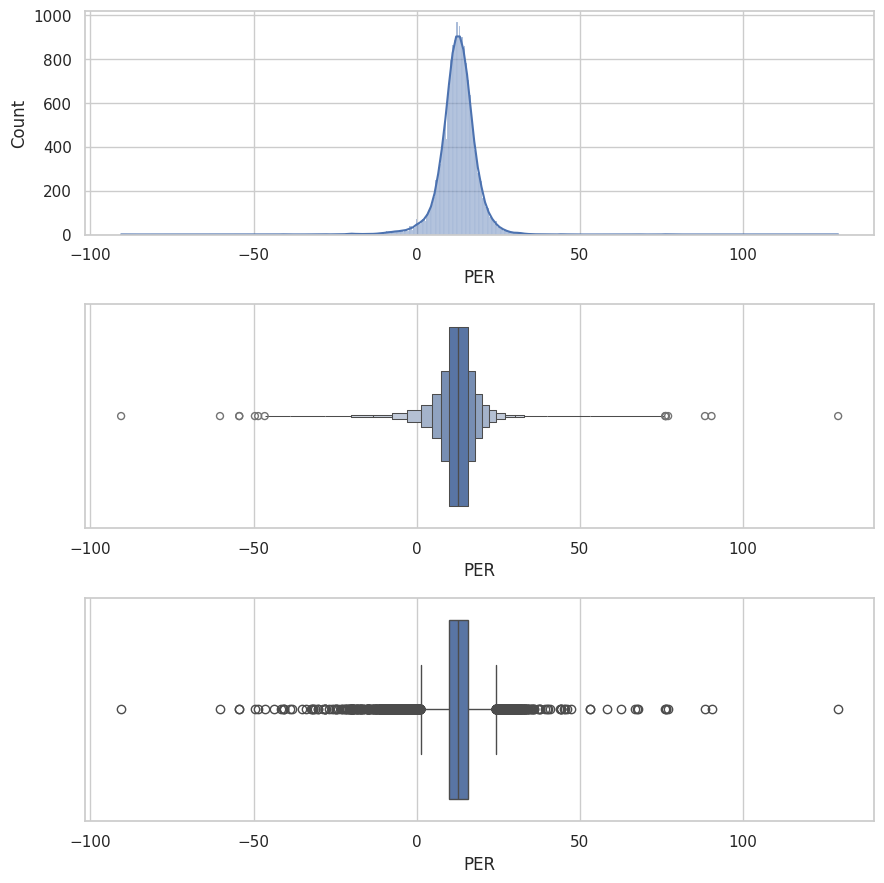

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 9))
sns.histplot(data=joined_df, x='PER', kde=True, ax=axes[0])
sns.boxenplot(data=joined_df, x="PER", ax=axes[1])
sns.boxplot(data=joined_df, x="PER", ax=axes[2])
fig.tight_layout()

In [34]:
# Выглядит странно. Посмотрим что внутри
joined_df["PER"].describe()

count    24696.000000
mean        12.471882
std          6.033758
min        -90.600000
25%          9.800000
50%         12.700000
75%         15.600000
max        129.100000
Name: PER, dtype: float64

In [35]:
"""
Если верить Википедии, средний PER лиги всегда равен 15.0
Всего 24 раза в истории НБА игрок заканчивал сезон с PER выше 30,0 (при условии участия минимум в 15 играх в сезоне). Самый высокий PER за сезон был зафиксирован у Янниса Адетокунбо в сезоне 2019/2020 и составил 31.86. Майкл Джордан и Леброн Джеймс провели по 4 сезона с PER выше 30,0, Шакил О’Нил и Уилт Чемберлен — по 3 сезона, Энтони Дэвис и Яннис Адетокунбо — по 2 сезона, Дэвид Робинсон, Дуэйн Уэйд, Крис Пол, Трэйси Макгрэди, Стефен Карри, Рассел Уэстбрук и Джеймс Харден — по одному сезону в карьере."""

# Следовательно, мы можем смело удалять из нашей таблицы все что ниже нуля и выше 32 
# Это даже не аутлееры, а просто испорченные данные

mask = (joined_df["PER"] < 0) | (joined_df["PER"] > 32)
records_to_delete = joined_df[mask].index
joined_df.drop(index=records_to_delete, inplace=True)

## histplot, boxenplot, boxplot

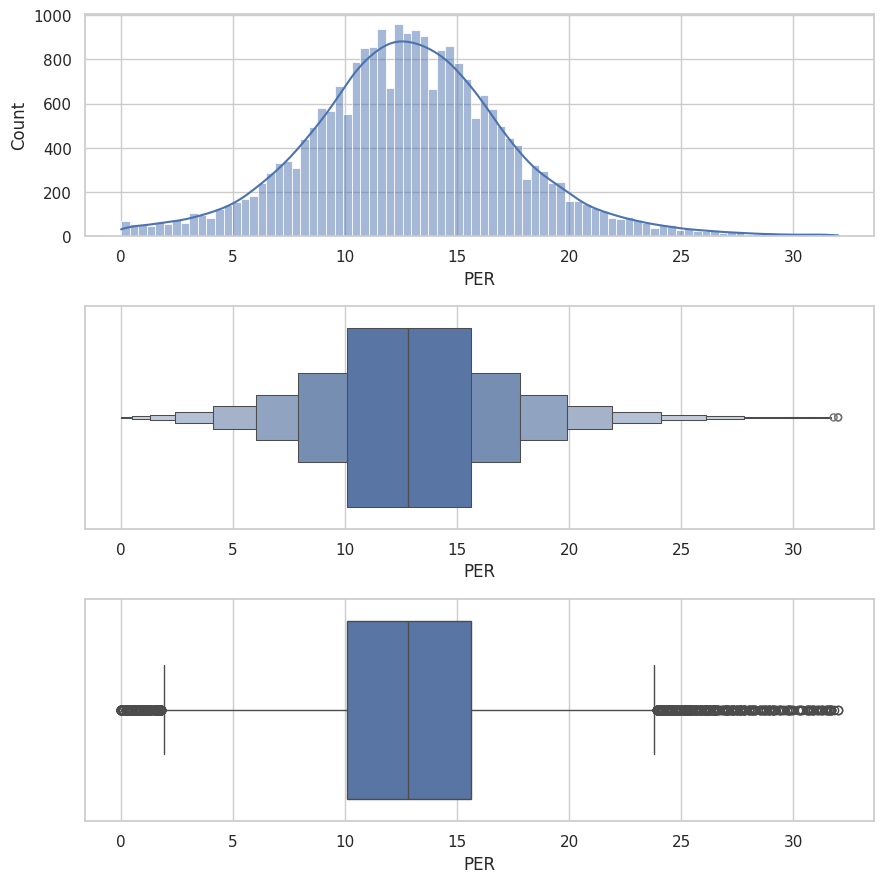

In [36]:
# И снова посмотрим на распределение и на "начинку" PER

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 9))
sns.histplot(data=joined_df, x='PER', kde=True, ax=axes[0])
sns.boxenplot(data=joined_df, x="PER", ax=axes[1])
sns.boxplot(data=joined_df, x="PER", ax=axes[2])
fig.tight_layout()

In [37]:
joined_df["PER"].describe()

count    24044.000000
mean        12.895209
std          4.605188
min          0.000000
25%         10.100000
50%         12.800000
75%         15.600000
max         32.000000
Name: PER, dtype: float64

## countplot

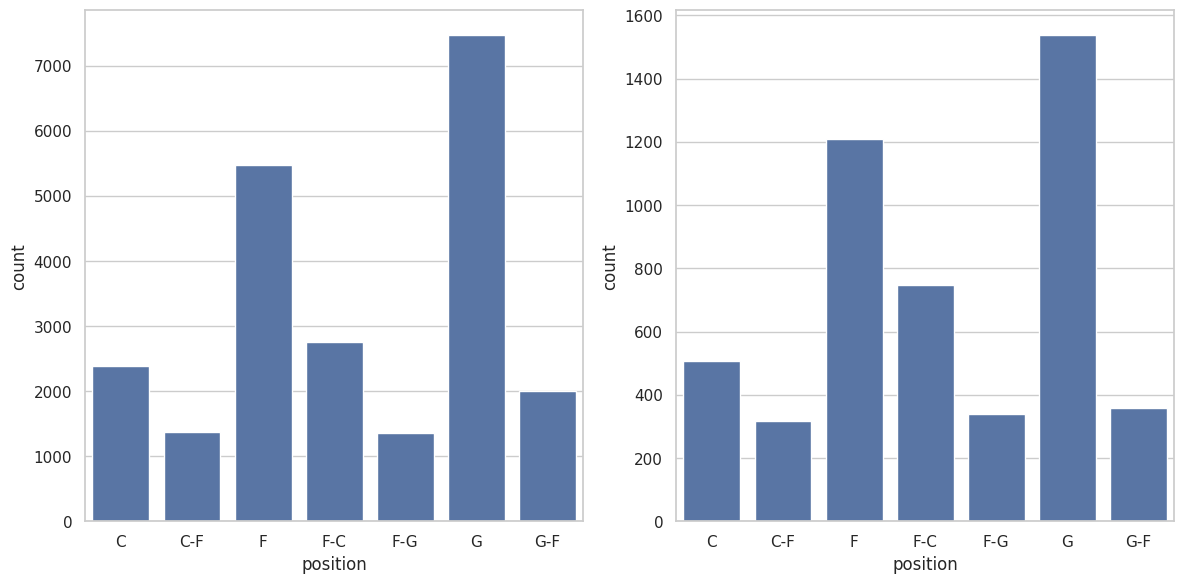

In [38]:
# Тем не менее видим весомое количество значений в верхней квантили 
# Интересно сопоставить как распределены амплуа игроков в целом по выборке 
# в сравнении с наиболее полезной четвертью игроков

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.countplot(data=joined_df.sort_values(by="position"), x="position", ax=axes[0])
sns.countplot(data=joined_df[joined_df["PER"] >= 15.6].sort_values(by="position"), x="position", ax=axes[1])
fig.tight_layout()

In [39]:
# Видим, что гистограммы практически идентичные. Это обусловлено тем, что, как уже говорилось, 
# PER - показатель интегральный и для каждого амплуа есть свои составляющие эффективности.

## jointplot

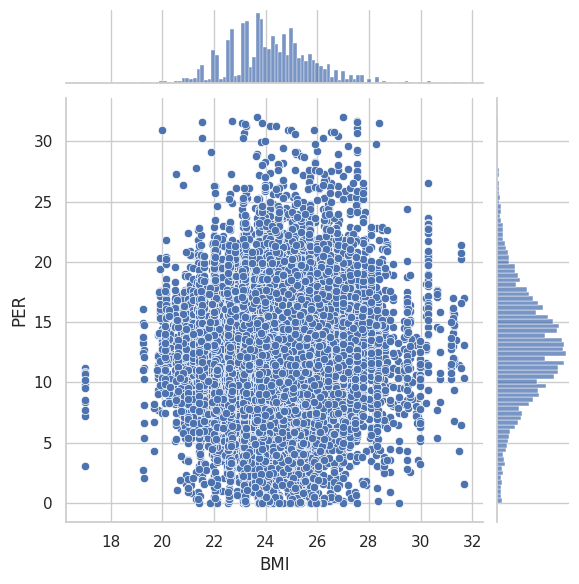

In [40]:
# Посмотрим как взаимосвязаны между собой рейтинг эффективности PER и индекс массы тела
sns.jointplot(x="BMI", y="PER", data=joined_df, kind="scatter");

In [41]:
# Видимо, никак не связаны, т.к. выраженной корреляции не наблюдается 

## lmplot

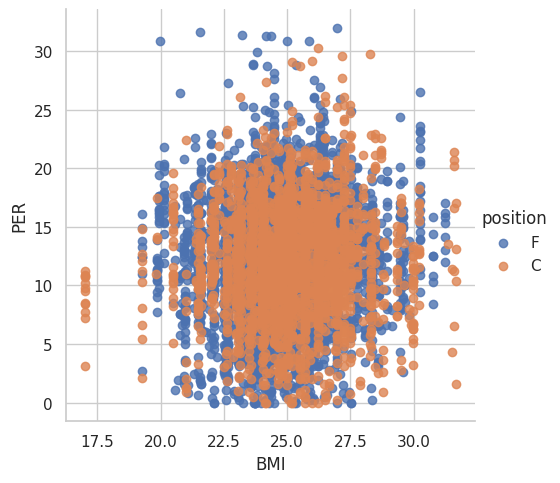

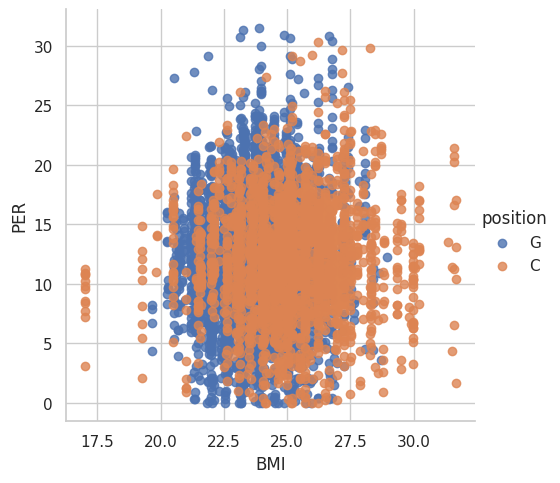

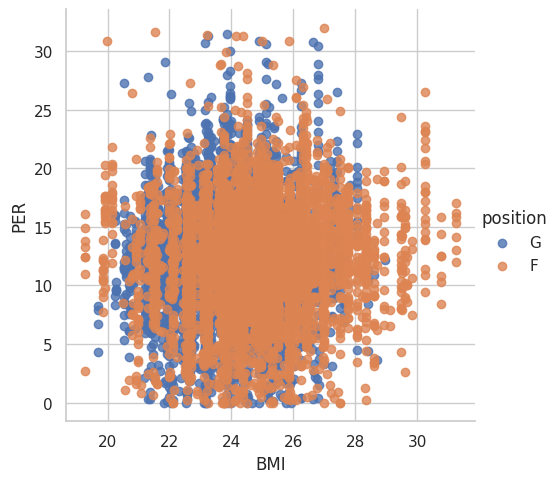

In [42]:
# Сопоставим отношение BMI и PER между основными амплуа - защитник G, центровой C, нападающий F

sns.lmplot(data=joined_df[joined_df["position"].isin(["F", "C"])], x="BMI", y="PER", hue="position", fit_reg=False)
sns.lmplot(data=joined_df[joined_df["position"].isin(["C", "G"])], x="BMI", y="PER", hue="position", fit_reg=False)
sns.lmplot(data=joined_df[joined_df["position"].isin(["G", "F"])], x="BMI", y="PER", hue="position", fit_reg=False)

In [43]:
# Отберем для последующего анализа основные физические характеристики игроков:
# Age - возраст
# height - рост
# weight - вес
# BMI - ИМТ

# И их основные показатели эффективности:
# PER - Player Efficiency Rating - уже знакомый нам рейтинг эффективноси игрока
# G - Games - сыграно игр
# MP - Minutes Played - провел минут на поле
# PTS - Points - заработал очков
# TRB - Total Rebounds - подборы
# AST - Assists - передачи
# STL - Steals - перехваты
# BLK - Blocks - блокированные броски
# TOV - Turnovers - возвраты мяча (если я правильно понял)
# PF - Personal Fouls - персональные фолы

KPIs = ["Age", "height", "weight", 
       "BMI", "PER", "G", "MP", "PTS", "TRB", "AST", "STL", "BLK", "TOV", "PF"]

## heatmap

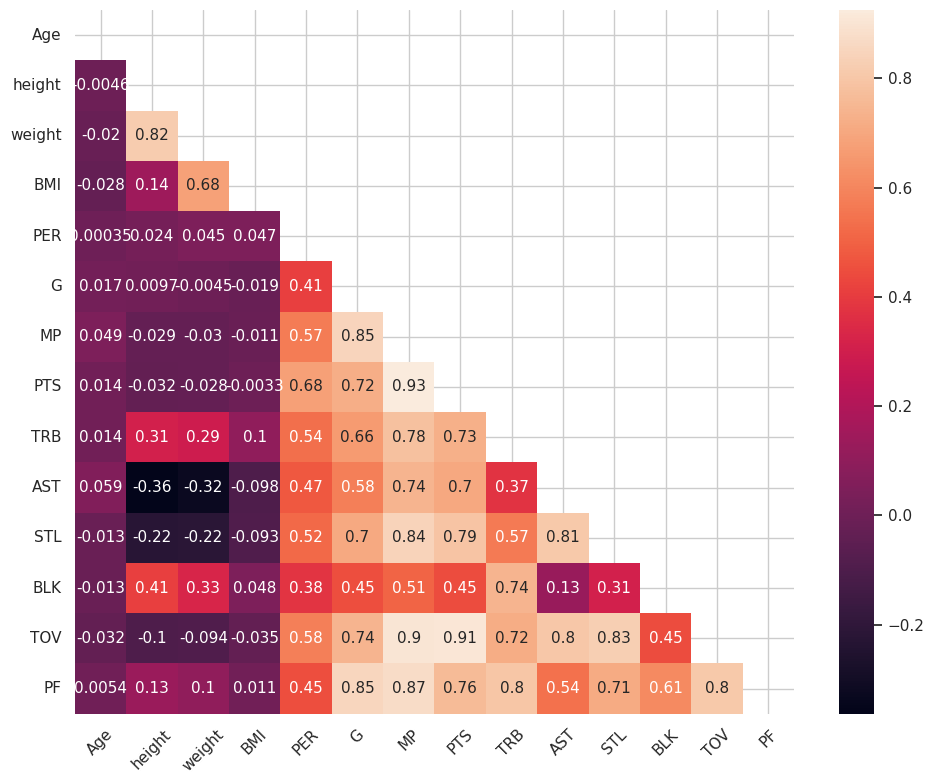

In [44]:
# Построим корреляционную матрицу
plt.figure(figsize=(10, 8))

corr_matrix = joined_df[KPIs].corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask=mask, annot=True, annot_kws={"fontsize":11})

plt.ylabel('')
plt.xlabel('')
plt.title('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# Наблюдаем практически полное отсутствие корреляции между физическими кондициями игроков 
# и их показателями эффективности. 
# Из этого следует, что конкретные физические кондиции игроков не являются определяющими 
# и каждый найдет свое место на площадке.
# Ясно, что существует входной порог - едва ли мы встретим в НБА людей с ростом 150 см )) 

# Однако стоит отметить слегка выраженную корреляцию между ростом, весом и такими показателями, 
# как подборы и блоки - основными функциями центровых. При этом, как мы выяснили ранее, 
# центровые - самые крупные ребята на площадке.

# Ожидаемая высокая корреляция между различными компонентами игры, например: 
# сыграно минут - набрано очков, перехваты - возвраты мяча, перехваты - ассисты.

# Отдельно стоит отметить, что показатель PER практически в равной степени коррелирует со 
# всеми игровыми KPI со значениями, близкими к 0.5, что говорит о его хорошей сбалансированности. 
# Чуть больше корреляция только с набранными очками, что также не является удивительным, т.к. 
# конечная цель игры именно в наборе очков.

## pairplot

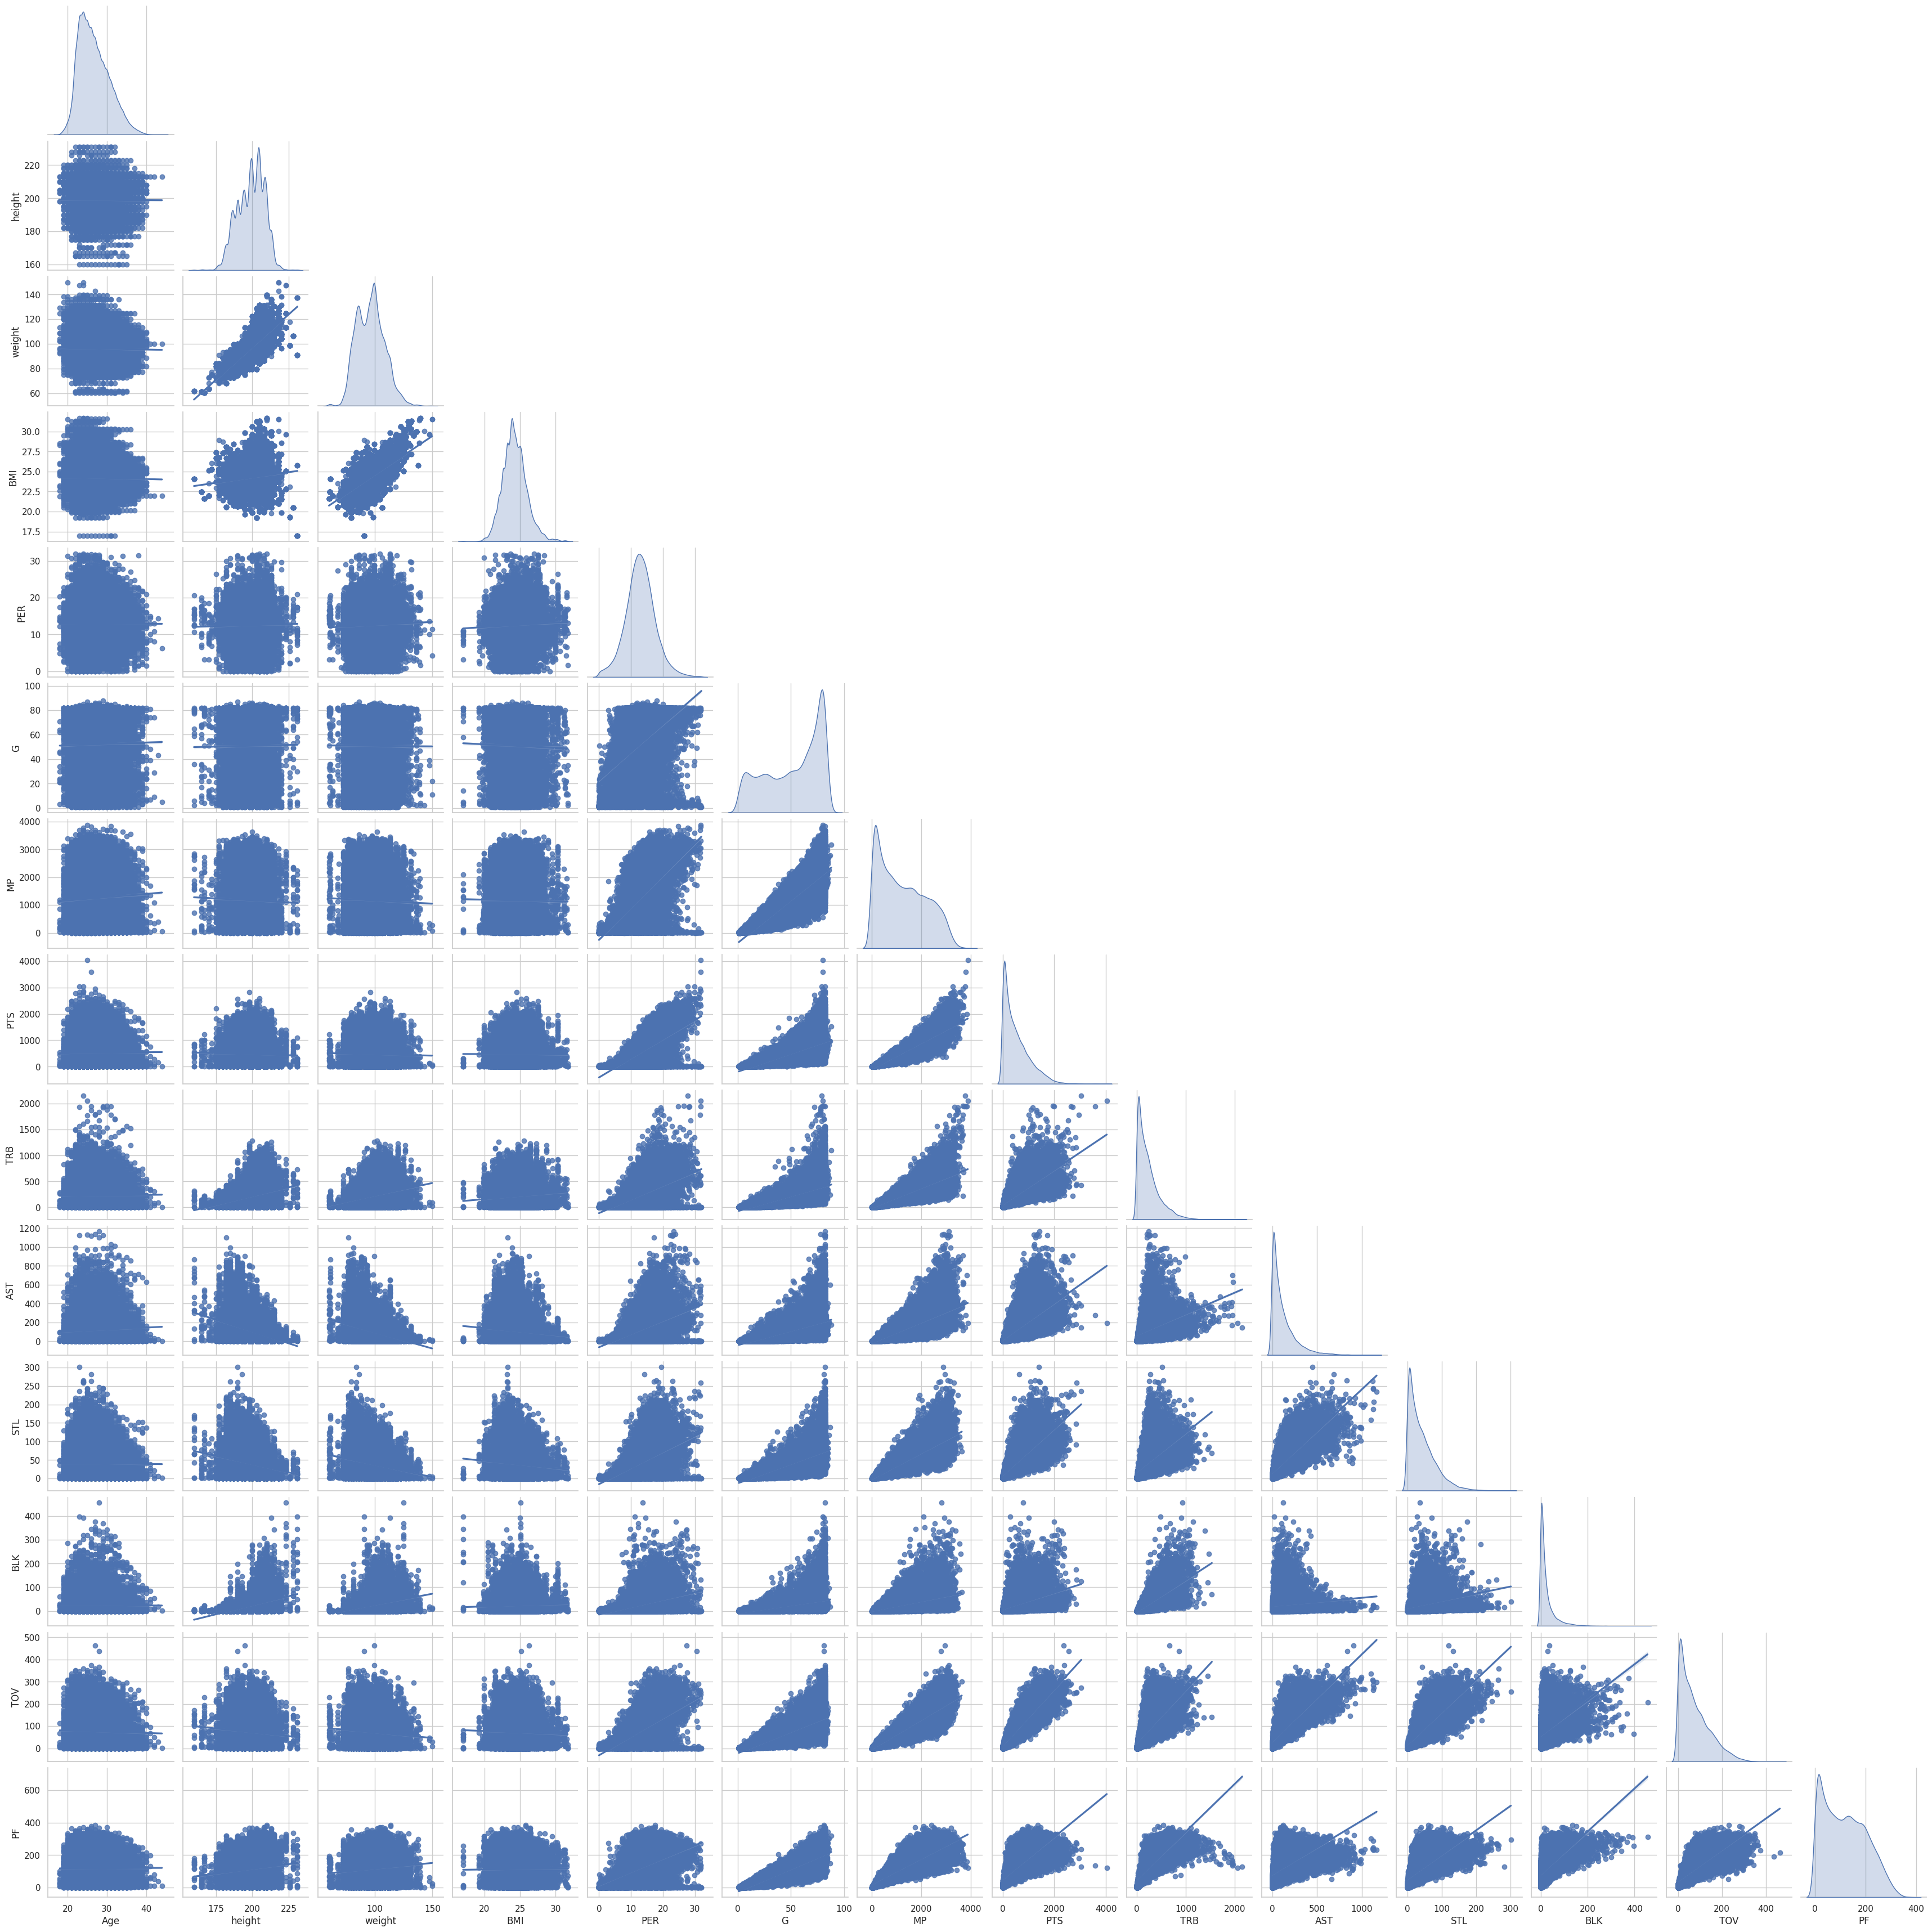

In [46]:
# Хотя мы уже примерно понимаем результат, посмотрим как это будет выглядеть на матрице рассеяния

sns.pairplot(joined_df[KPIs], corner=True, kind="reg", diag_kind="kde");

In [47]:
# как отмечало ранее, на графиках заметны корреляции игровых KPI между собой.

In [48]:
# Интересно посмотреть есть ли взаимосвязь между колледжем, где учился игрок и его достижениями. 
# Но поскольку в таблице joined_df присутствуют данные для всех игроков по всем сезонам, 
# те игроки, карьеры которых продлились дольше, будут иметь большее влияние на результат. 
# Поэтому нам следует вернуться к датафрейму players_df где одному игроку соответствует одна запись 
# и добавить средний за карьеру данного игрока коэффициент PER туда.

mean_PER = joined_df.groupby(by=["Player"])["PER"].mean().to_frame()
players_df = players_df.merge(mean_PER, how="left", left_on="name", right_on="Player")

In [49]:
# Посчитаем количество игроков по колледжам 
colleges = players_df.groupby(by="college")["name"].count()

colleges.describe()

count    473.000000
mean       8.974630
std       13.718855
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max       99.000000
Name: name, dtype: float64

## bar plots

<Axes: xlabel='college'>

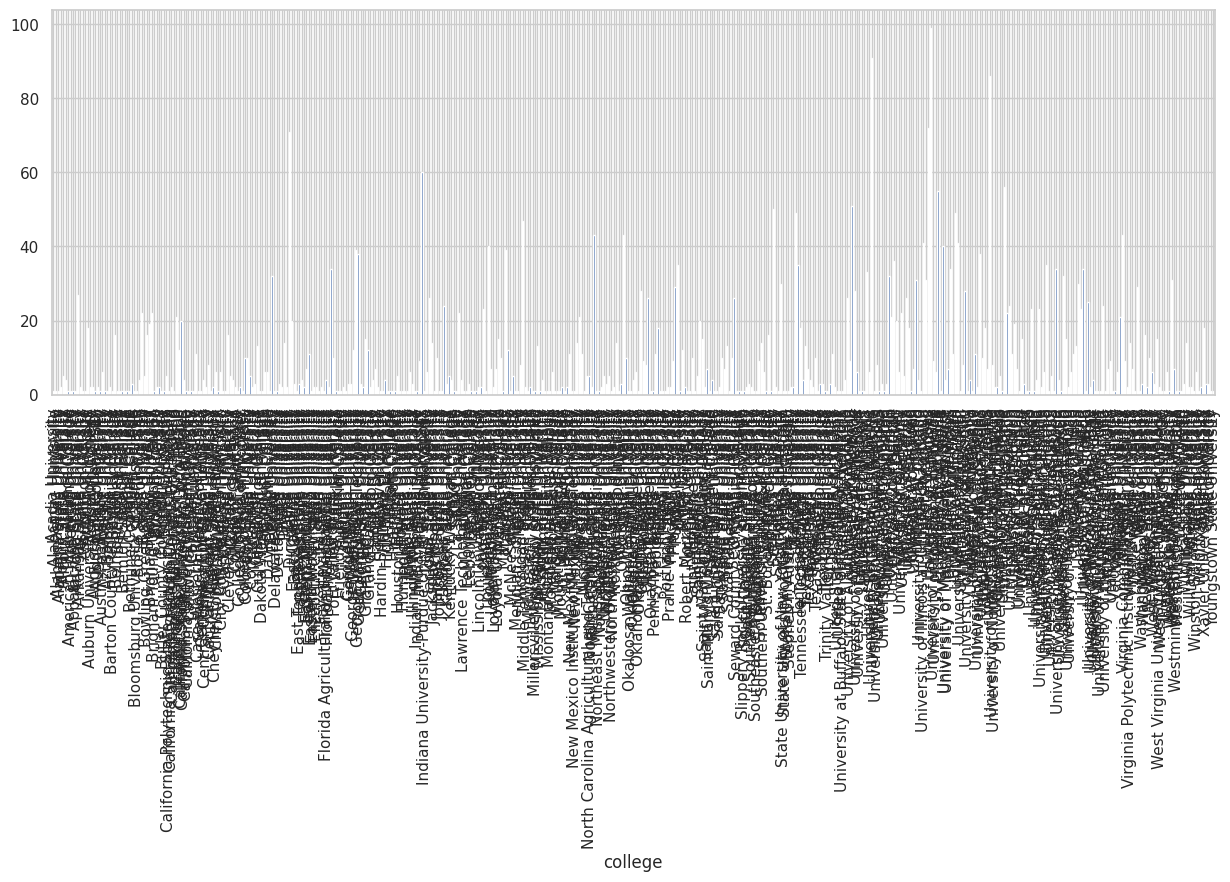

In [50]:
plt.figure(figsize=(15, 5))
colleges.plot.bar()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'University of Kentucky'),
  Text(1, 0, 'University of California, Los Angeles'),
  Text(2, 0, 'University of North Carolina'),
  Text(3, 0, 'University of Kansas'),
  Text(4, 0, 'Duke University'),
  Text(5, 0, 'Indiana University'),
  Text(6, 0, 'University of Notre Dame'),
  Text(7, 0, 'University of Louisville'),
  Text(8, 0, 'University of Arizona'),
  Text(9, 0, "St. John's University"),
  Text(10, 0, 'University of Michigan'),
  Text(11, 0, 'Syracuse University'),
  Text(12, 0, 'Michigan State University'),
  Text(13, 0, 'Ohio State University'),
  Text(14, 0, 'North Carolina State University'),
  Text(15, 0, 'Villanova University'),
  Text(16, 0, 'University of Illinois at Urbana-Champaign'),
  Text(17, 0, 'University of Minnesota'),
  Text(18, 0, 'University of Maryland'),
  Text(19, 0, 'Louisiana State University')])

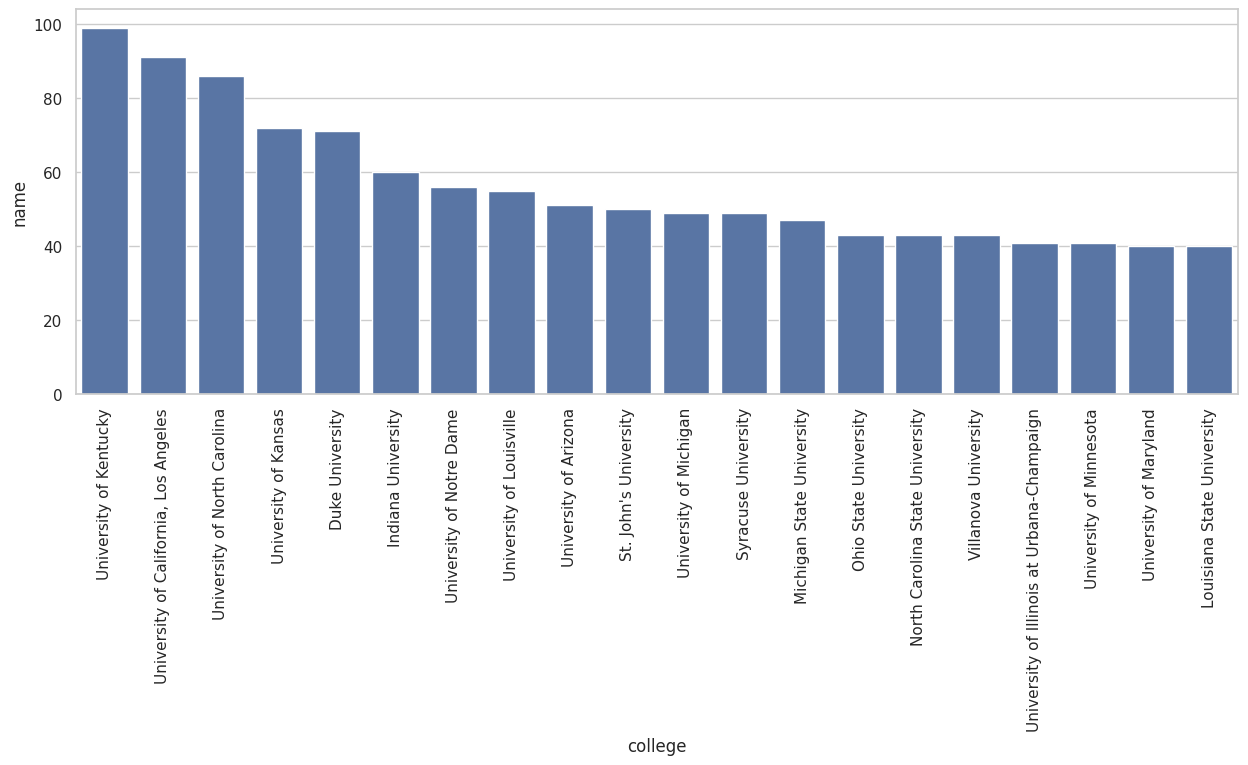

In [51]:
# Из describe и графика видно, что большинство колледжей дали в лигу менее 11 игроков (квартиль 75%). 
# Посмотрим на первую двадцатку

top_20_colleges = colleges.sort_values(ascending=False).iloc[:20]

plt.figure(figsize=(15, 5))
sns.barplot(top_20_colleges)
plt.xticks(rotation=90)

In [52]:
# А теперь отберем четверть лучших игроков PER > 15,6 (это значение квартили 75%) 
# и посмотрим топ 20 колледжей где учились они.

best_players = players_df[players_df["PER"]>15.6]

best_players_colleges = best_players.groupby(by="college")["name"].count()

best_players_colleges.describe()

count    148.000000
mean       2.101351
std        1.940404
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: name, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'University of North Carolina'),
  Text(1, 0, 'Duke University'),
  Text(2, 0, 'University of California, Los Angeles'),
  Text(3, 0, 'University of Kentucky'),
  Text(4, 0, 'University of Kansas'),
  Text(5, 0, 'University of California'),
  Text(6, 0, 'University of Michigan'),
  Text(7, 0, 'University of Notre Dame'),
  Text(8, 0, 'University of Connecticut'),
  Text(9, 0, 'Purdue University'),
  Text(10, 0, 'University of Southern California'),
  Text(11, 0, 'University of Texas at Austin'),
  Text(12, 0, 'Boston College'),
  Text(13, 0, 'Georgia Institute of Technology'),
  Text(14, 0, 'Wake Forest University'),
  Text(15, 0, 'University of Florida'),
  Text(16, 0, 'University of Oklahoma'),
  Text(17, 0, 'University of Arkansas'),
  Text(18, 0, 'Ohio State University'),
  Text(19, 0, 'Syracuse University')])

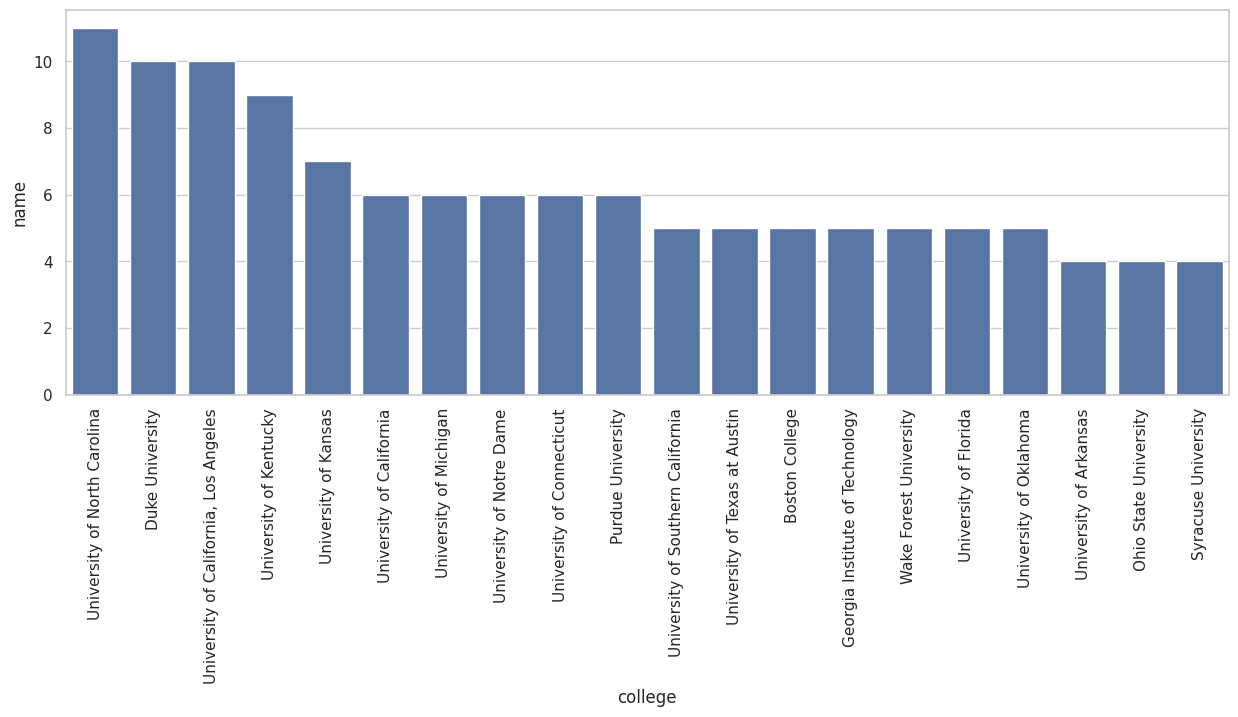

In [53]:
best_player_top_20_colleges = best_players_colleges.sort_values(ascending=False).iloc[:20]

plt.figure(figsize=(15, 5))
sns.barplot(best_player_top_20_colleges)
plt.xticks(rotation=90)

In [54]:
# Посмотрим насколько пересекаются список колледжей, выпустивших максимальное количество игроков 
# со списком колледжей, выпустивших максимальное количество хороших игроков

set(best_player_top_20_colleges.index) & set(top_20_colleges.index)


{'Duke University',
 'Ohio State University',
 'Syracuse University',
 'University of California, Los Angeles',
 'University of Kansas',
 'University of Kentucky',
 'University of Michigan',
 'University of North Carolina',
 'University of Notre Dame'}

In [55]:
# Следующий список - это колледжи, которые в топ 20 по хорошим игрокам, 
# но не входят в топ 20 по общему количеству игроков.
# Возможно в них особо удачная программа подготовки спортсменов и желающим к ним стоит присмотреться

set(best_player_top_20_colleges.index) - set(top_20_colleges.index)

{'Boston College',
 'Georgia Institute of Technology',
 'Purdue University',
 'University of Arkansas',
 'University of California',
 'University of Connecticut',
 'University of Florida',
 'University of Oklahoma',
 'University of Southern California',
 'University of Texas at Austin',
 'Wake Forest University'}